In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import sys
# sys.path.append('/Users/evanli/Documents/EvanPys/Progress')
# sys.path.append('/home/jovyan/work/GitHub/EvanPys/Progress')
# sys.path.append(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress')
sys.path.append(str(source_code_dir))
from ADlasso2 import AD2_w_utils_lossdiff_noZ as ad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import json
import copy

In [3]:
import scanpy as sc
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_L1_repcells_loginv_Harmony_noZ.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')

label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print(types)
print(adata.shape)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']
(59897, 27504)


In [3]:
clus_2_ACT_name = {
 'B': 'B cell',
 'CD4_T': 'CD4-positive, alpha-beta T cell',
 'CD8_T': 'CD8-positive, alpha-beta T cell',
 'DC': 'Dendritic cell',
 'Mono': 'Monocyte',
 'NK': 'Natural killer cell'
}


In [4]:
# Read ACT markers
marker_df = pd.read_csv('Human_blood_marker_processed.csv')
print(marker_df.shape)
marker_df.head()

(147, 6)


,Species,Tissue,super_type,CellType,Marker,Resource
0,Human,Blood,B,Activated B cell,"CD5, MIR155HG, TAGLN2","35025971, 28910360, 2474446"
1,Human,Blood,T_CD4,"Activated CD4-positive, alpha-beta T cell","CD4, CCR6, CD14, CD19, CD38, CD3D, CD3G, CD69,...","35381424, 32783921, 35831277, 34529726, 103413..."
2,Human,Blood,T_CD4,"Activated CD4-positive, CD25-positive, CCR4-po...","CD3D, CD3E, CD3G, CD4, FOXP3",30977974
3,Human,Blood,NaN,Adult endothelial progenitor cell,"KDR, PROM1, CD34, PTPRC, PECAM1, CD14","27561827, 29391882, 24641802, 29147957, 267700..."
4,Human,Blood,T,Alpha-beta T cell,"CD3D, CD3E, CD3G, IL7R","34284174, 28777444"


In [5]:
def get_celltype_marker(name, marker_df):
    string = marker_df[marker_df['CellType'] == name]['Marker'].tolist()[0]
    marker_list = string.split(', ')
    return marker_list

In [4]:
# Read PreLect and ACT overlap
# with open(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\ACT_annotation\L1_PreLect_ACT_overlap.json", 'r') as f:
#     overlapped_dict = json.load(f)
with open(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/ACT_annotation/L1_PreLect_ACT_overlap.json', 'r') as f:
    overlapped_dict = json.load(f)
overlapped_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK'])

## Plot prevalence scatter

In [7]:
from scipy.sparse import *

def featureProperty_evan(X, y, data_point_status, is_ACT_binary=[]):
    # y: celltype binary label, needs to be 0 and 1
    # is_ACT_binary: whether the gene belongs to ACT markers, binary, needs to be 0 and 1
    def scipySparseVars(a, axis=None):  # requried function
        a_squared = a.copy()
        a_squared.data **= 2
        return a_squared.mean(axis) - np.square(a.mean(axis))
    
    if type(X) is pd.DataFrame:
        X = X.to_numpy()
    
    if type(X) is np.ndarray:
        nonzeroSamples = X.sum(axis=1) != 0
        X_ = X[nonzeroSamples,:]
        y_ = y[nonzeroSamples]
        
        XF = X_/X_.sum(axis=1)[:,None]
        RA = XF.mean(axis = 0)
        Var = X_.std(axis = 0)**2

    elif isspmatrix_csr(X) or isspmatrix_csc(X) or isspmatrix_coo(X):
        rowSum = X.sum(axis=1).reshape(-1)
        nonzeroSamples = np.array(rowSum != 0)[0]
        X_ = X[nonzeroSamples,:]
        y_ = y[nonzeroSamples]
        RA = X_.mean(axis = 0); RA = np.array(RA).reshape(-1) #XF
        Var = scipySparseVars(X_, axis = 0); Var = np.array(Var).reshape(-1)
        
    else :
        raise ValueError("X is unrecognizable data types")
        
    # selection = ["PreLect" if i == 1 else "No selected" for i in AD_object.feature_set]
    is_ACT = ["ACT" if i == 1 else "not_ACT" for i in is_ACT_binary]
    class0Idx = np.array([i for i, la in enumerate(y_) if la == 0])
    class1Idx = np.array([i for i, la in enumerate(y_) if la == 1])
    wholePvl = ad.get_prevalence(X_, np.arange(X_.shape[0]))
    class0Pvl = ad.get_prevalence(X_, class0Idx)
    class1Pvl = ad.get_prevalence(X_, class1Idx)
    
    C0head = 'prevalence_0'  # + str(list(AD_object.classes_.keys())[0])  # class 0 prevalence
    C1head = 'prevalence_1'  # + str(list(AD_object.classes_.keys())[1])  # class 1 prevalence
    plotdf = pd.DataFrame({'meanAbundance' : RA,'Variance' : Var, 'select' : data_point_status, 'prevalence' : wholePvl, C0head : class0Pvl, C1head : class1Pvl})
    return plotdf
    
def plot_feature_property(adata, Y, data_point_status, clus_name='', is_ACT_binary=[]):
    # Get feature property
    prop = featureProperty_evan(adata.X, Y, data_point_status)
    prop['featureID'] = adata.var_names
    # print(prop.head())

    # Plot feature property
    # Filter the data
    # ACT_and_PreLect, ACT_not_PreLect, not_ACT
    ACT_and_PreLect_data_points = prop[prop['select'] == 'ACT_and_PreLect']
    ACT_not_PreLect_data_points = prop[prop['select'] == 'ACT_not_PreLect']
    not_ACT_data_points = prop[prop['select'] == 'not_ACT']
    # other_data = prop[prop['select'] == 'No selected']

    # Plot the not_ACT dots with grey color and alpha=0.5
    sns.scatterplot(x="prevalence_1", y="prevalence_0", color='#BCBCBC', alpha=0.5, data=not_ACT_data_points, label='not_ACT')
    # Plot the negative dots with blue color and alpha=1
    sns.scatterplot(x="prevalence_1", y="prevalence_0", color='b', alpha=1, data=ACT_not_PreLect_data_points, label='ACT_not_PreLect')
    # Plot the ACT dots with red color and alpha=1
    sns.scatterplot(x="prevalence_1", y="prevalence_0", color='r', alpha=1, data=ACT_and_PreLect_data_points, label='ACT_and_PreLect')

    # Get the current axes
    ax = plt.gca()

    # Get the handles and labels from the scatterplot
    handles, labels = ax.get_legend_handles_labels()
    order = [2, 1, 0]
    # Set the legend
    plt.legend(handles=[handles[idx] for idx in order], labels=[labels[idx] for idx in order], loc='upper left', fontsize='small')
    # plt.legend(loc='upper left', fontsize='small')
    plt.xlabel('Target prevalence')
    plt.ylabel('Other prevalence')
    plt.title(f'ACT markers of {clus_name}')
    plt.savefig(f'{clus_name}_ACT_pvl_scatter.png', dpi=300)
    plt.show()
    plt.close('all')
    # del adata

In [8]:
adata.var_names

Index(['MIR1302-2HG', 'OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.4',
       'AL669831.2', 'AL669831.5', 'FAM87B', 'LINC00115', 'FAM41C',
       ...
       'AC007325.1', 'AC007325.4', 'AC007325.2', 'AL354822.1', 'AC023491.2',
       'AC004556.1', 'AC233755.2', 'AC233755.1', 'AC240274.1', 'FAM231C'],
      dtype='object', length=27504)

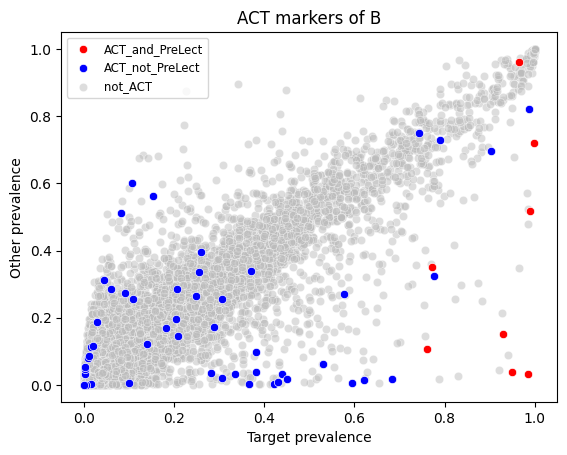

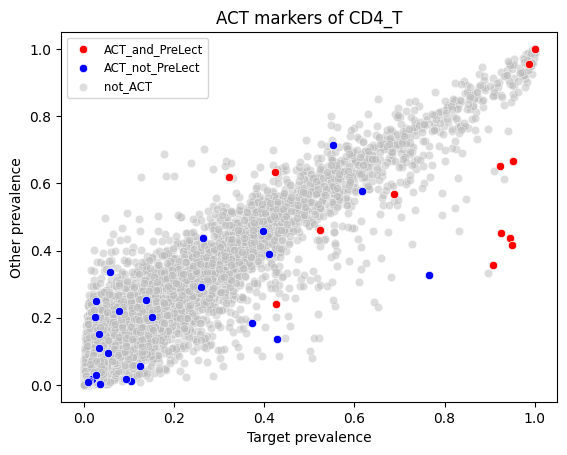

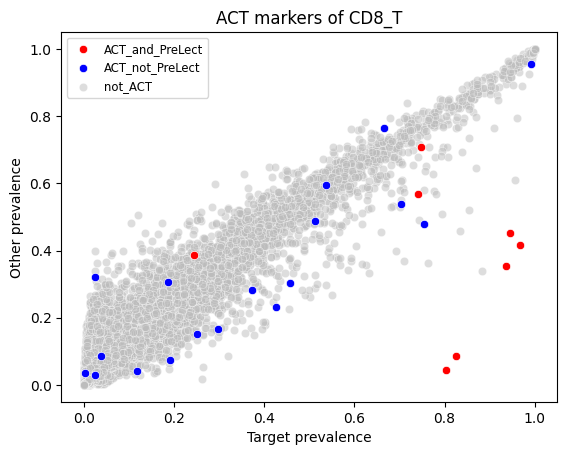

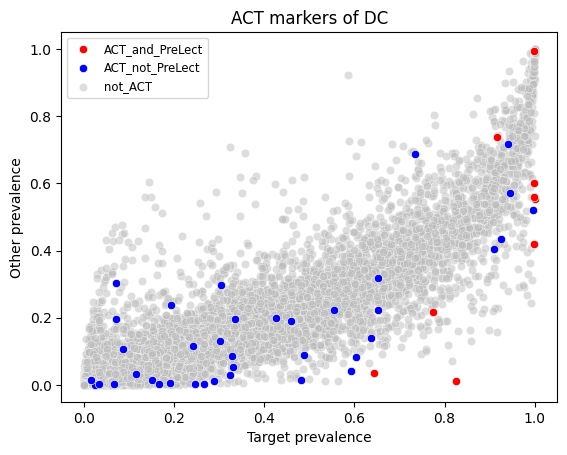

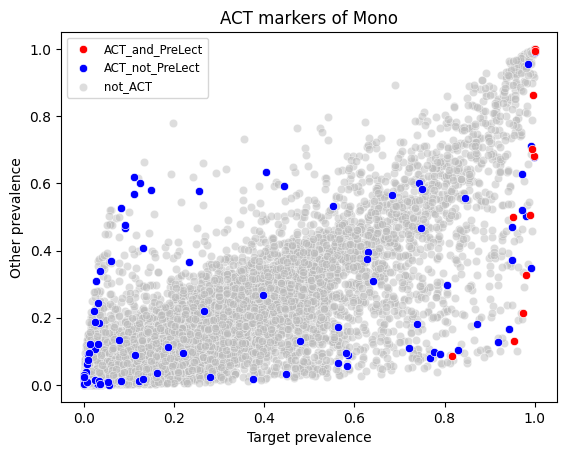

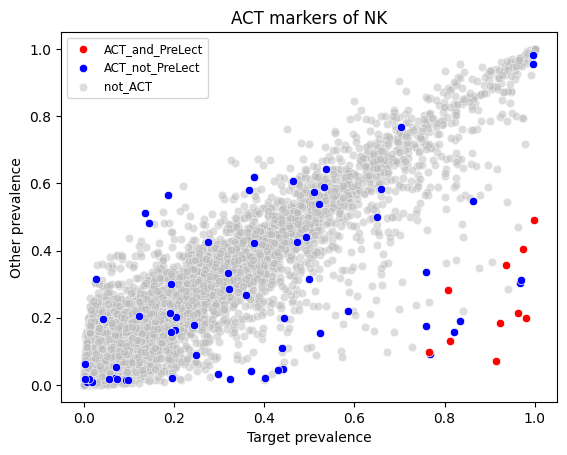

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\ACT_annotation\Prevalence_scatter_ACT_marker")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/ACT_annotation/Prevalence_scatter_ACT_marker')

for clus, name in clus_2_ACT_name.items():
    marker_list = get_celltype_marker(name, marker_df)
    # print(clus, marker_list)
    # is_ACT_binary = np.array([1 if gene in marker_list else 0 for gene in adata.var_names])
    # print(len(is_ACT_binary))
    # print(sum(is_ACT_binary))

    # whether a genes belongs to: ACT_and_PreLect, ACT_not_PreLect, not_ACT
    ACT_status = []
    for gene in adata.var_names:
        if gene in overlapped_dict[clus]:
            ACT_status.append('ACT_and_PreLect')
        elif (gene not in overlapped_dict[clus]) and (gene in marker_list):
            ACT_status.append('ACT_not_PreLect')
        else:
            ACT_status.append('not_ACT')

    # Binary classification of a celltype
    celltype_label = np.array([1 if x == clus else 0 for x in label])
    plot_feature_property(adata, celltype_label, ACT_status, clus)